<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initial-setup" data-toc-modified-id="Initial-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initial setup</a></span><ul class="toc-item"><li><span><a href="#Load-the-results" data-toc-modified-id="Load-the-results-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the results</a></span></li><li><span><a href="#Load-population-data" data-toc-modified-id="Load-population-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load population data</a></span></li></ul></li><li><span><a href="#Seting-up-the-indicator-components" data-toc-modified-id="Seting-up-the-indicator-components-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Seting up the indicator components</a></span><ul class="toc-item"><li><span><a href="#Energy-Requirements-($R_t$)-depending-on-Household-Characteristics" data-toc-modified-id="Energy-Requirements-($R_t$)-depending-on-Household-Characteristics-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Energy Requirements ($R_t$) depending on Household Characteristics</a></span></li><li><span><a href="#Compute-Energy-Cost-($F_t^j$)" data-toc-modified-id="Compute-Energy-Cost-($F_t^j$)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Compute Energy Cost ($F_t^j$)</a></span></li><li><span><a href="#Plot-envelope-$F_t^j$" data-toc-modified-id="Plot-envelope-$F_t^j$-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot envelope $F_t^j$</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span></li></ul></div>

# Initial setup

In [9]:

'''
Created by Angela M. Rojas A. <angelara@student.unimelb.edu.au>


Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob



## Load the results

In [10]:
from ema_workbench import load_results

#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-20-years.tar.gz')
#results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Feb-07_EET_allV3.tar.gz')
results = load_results(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\data\gr4sp_2020-Mar-05-SOBOL.tar.gz')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\data\\gr4sp_2020-Mar-05-SOBOL.tar.gz'

In [ ]:
experiments, outcomes = results

# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [ ]:
experiments.head()

In [ ]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# numActorsYear
outcomes_to_show = ['GHGYear','wholesalePriceYear', 'tariffsYear','primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'rooftopPVProductionYear' ]

# 22 levers selected after EET
levers = ['consumption', 'energyEfficiency', 'rooftopPV', 'solarUptake','annualCpi','annualInflation',
          'includePublicallyAnnouncedGen','generationRolloutPeriod','generatorRetirement','technologicalImprovement',
          'priceChangePercentageBrownCoal','priceChangePercentageWind','priceChangePercentageWater','capacityFactorChangeBrownCoal','capacityFactorChangeWater',
          'distributionUsageChange','retailUsageChange',
          'semiScheduleGenSpotMarket','semiScheduleMinCapMarketGen', 'nonScheduleGenSpotMarket', 'nonScheduleMinCapMarketGen', 
          'learningCurve' ]

#from startYear
startYear = 1998
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
simulationYears = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
simulationYears_dateTime = pd.to_datetime(simulationYears, format = '%Y')


## Load population data

Filter by area code

In [ ]:
region = 'VIC'

household_type = pd.read_csv('postgres_public_household_forecast_victoria.csv')
region_household_type = household_type[ household_type['region'] == region]
region_household_type.head()

Perform linear interpolation to fill missing years

In [ ]:
#Create new years from startYear to max, and Interpolate missing values
years_interpolate = pd.DataFrame({"TIMEYear" : np.arange(region_household_type['TIMEYear'].min(), region_household_type['TIMEYear'].max()+1, 1)})
merged = pd.merge(years_interpolate, region_household_type, how='left',on='TIMEYear')
region_household_type = merged.interpolate(method='linear', limit_direction='forward', axis=0)
region_household_type = region_household_type.ffill()
region_household_type = region_household_type.set_index(region_household_type['TIMEYear'])
region_household_type.head(10)

Show percentage of familiy composition as a function of total number of households

In [ ]:
region_household_type_percentage = region_household_type.copy()
for col in ['couple_with_children', 'couple_without_children', 'one_parent_family','other_family','group_household','lone_person']:
    region_household_type_percentage[col] /= region_household_type_percentage['all_household_types']

region_household_type_percentage.head()

# Seting up the indicator components

![caption](LIHC_Modified.png)



## Energy Requirements ($R_t$) depending on Household Characteristics

$C_t^j = R_t^j * P where $R_t^j$ is energy requirement  for space conditioning, water heating, lights, appliances and cooking used in year $t$ in simulation run $j$. This energy requirement depend on household characteristics of size, age of property, occupancy level, fuel mix, and family type. 

Note that $R_t$ is the minimum energy requirement and remains constant across simulations. For any two simulation runs $j$ and $i$, where $j\neq i$, any change in $C_t^j \neq C_t^i$ affects only the household characteristics value $A_t^j$. This is consistent with the interventions modeled in the simulation, as they affect only the building energy efficiency and belong to $A_t^j$.

Lets first convert household consumption $C_t^j$ expressed in $KWh$ into total residential consumtion in $MJ$

In [ ]:
kwh_to_mj = 3.6
mj_to_kwh = 1/kwh_to_mj

mj_to_mwh = mj_to_kwh / 1000
mwh_to_mj = 1 / mj_to_mwh

mj_to_pj = 10 ** -9
pj_to_mj = 1/ mj_to_pj

pj_to_mwh = pj_to_mj * mj_to_mwh
pj_to_kwh = pj_to_mj * mj_to_kwh

mwh_to_pj = 1 / pj_to_mwh
kwh_to_pj = 1 / pj_to_kwh

In [ ]:
#Columns are years from 0,..,t
C_j = (outcomes['consumptionYear'] * outcomes['numConsumersYear']) * kwh_to_mj
C_j_df = pd.DataFrame( C_j, columns=outcomes['TIMEYear'][0])
C_j_df.head()

Consumption in the simulation can vary depedning on the forecasts from ISP on:

* consumption: ISP Forecast # consumptions = OpSentOut + PV + EE + ONSG
* energyEfficiency (EE): ISP Forecast # consumption = consumption - EE
* onsiteGeneration (ONSG): ISP Forecast # consumption = consumption - ONSG
* solarUptake (PV): ISP Forecast #Slow change

ISP Forecast scenarios are: Central, Step, Slow, Fast and Hight DER

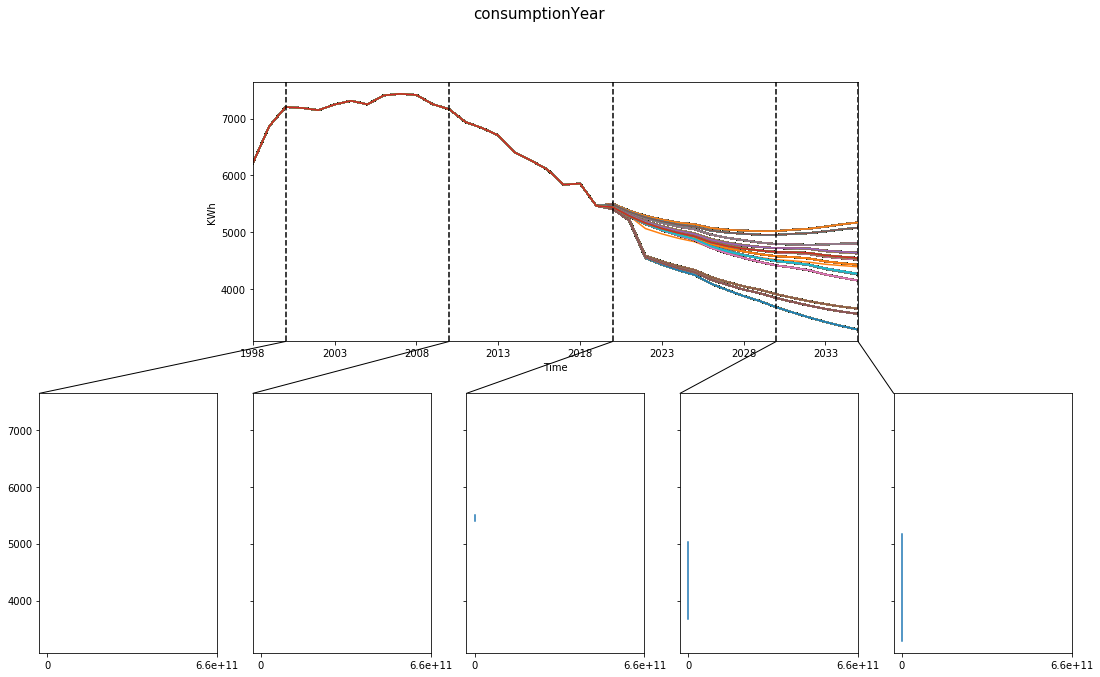

In [57]:

from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 
ooi = 'consumptionYear'

fig, ax_env = multiple_densities(experiments, outcomes, outcomes_to_show = ooi,
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: "KWh"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env[ooi]['main plot'].set_xticklabels(simulationYears[range(0,len(simulationYears),5)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

$B_t$ is taken from th Australian report excel spreadsheet on tabs "Energy.Elec.EndUse-State" and "Energy.Fuel-State" which contains the "Total Electric Energy by End Use - Australia and States (PJ)" and "Total Energy by Fuel - Australia and States (PJ)" -including gas, LPG and wood- from the year 2000 to 2030. We assumed that this will be the energy requirement.

In [ ]:
B_df = pd.read_csv('energy_use_vic_pj.csv')

Convert from _PJ_ to _MJ_ all columns but the year

In [ ]:
B_df.loc[:, B_df.columns != 'TIMEYear'] = B_df.loc[:, B_df.columns != 'TIMEYear'] * pj_to_mj

[This approach using pandas](https://www.machinelearningplus.com/time-series/time-series-analysis-python/) was tried, section 15: How to treat missing values in a time series?, but didn't work, as it simply copied the last values forward and backward using `ffill()` and `bfill()`. Interpolation didn't work either `df.interpolate(method='linear', limit_direction='forward', axis=0)`.

Instead, [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) library was used. 

Add missing years in `B_j` dataframe to match simulation years (will be NaN for missing values), and fill the missing backward values with `bfill()` as prophet doesn't backcast. In this example is only 2 time points _1996-1998_.

In [ ]:
years_interpolate = pd.DataFrame( {"TIMEYear" : simulationYears} )
merged = pd.merge(years_interpolate, B_df, how='left',on='TIMEYear')

merged = merged.bfill()

The data is formatted so we can do the forecast. A column `ds` for dates, and a column `y` for data.  Fit a model to the historical data of the columns.

In [ ]:
from fbprophet import Prophet

#Use Date format
merged["TIMEYear"] = simulationYears_dateTime
merged.rename(columns={"TIMEYear": "ds"}, inplace=True)

columns_prediction = ["Appliances","Cooking","Lighting","Space conditioning",
                      "Water heating", "Natural Gas","LPG","Wood"]

for col in columns_prediction:
    #Rename Column of interest
    merged.rename(columns={col:"y"}, inplace=True)
    
    #Fit the model
    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(merged)    
    
    #make prediction
    future = m.make_future_dataframe(periods=0, freq='Y',include_history=True)
    forecast = m.predict(future)    
    #fig1 = m.plot(forecast)
    
    #Incorporate the prediction only for the NaN values
    nans = merged.isnull().any(axis=1)
    merged['y'][nans] = forecast['yhat'][nans]
    
    #Rename the column back to original name
    merged.rename(columns={"y":col}, inplace=True)
    
#Recover original Date format
merged.rename(columns={"ds":"TIMEYear"}, inplace=True)
merged["TIMEYear"] = simulationYears

__Total Electricity__ cannot be predicted, as it will not match the sum over the previous columns. Those predictions are summed to get the __Total Electricity__ prediction

In [ ]:
merged["Total Electricity"] = merged[ ["Appliances","Cooking","Lighting","Space conditioning","Water heating"] ].sum(axis=1)  

Copy the predicted values back to $B_t$

In [ ]:
B_df = merged.round(decimals=2)
B_df.tail()

$A_t^j = C_t^j - B_t$

In [ ]:
A_j_df = C_j_df - list(B_df['Total Electricity'])

A_j_df.head(10)

<div class="alert alert-block alert-info"><b>Tip:</b> 
$A_t^j$ is now ready to be used according to household characteristics using building stock data (Size, Age, etc.). In this way we can recompute $C_t^j$ given the distribution of households

</div>

## Compute Energy Cost ($F_t^j$)

$F_t^j = E_t^j * C_t^j$, where $F_t^j$ stands for the energy cost in year $t$ for simulation $j$. 

$C_t^j$ is given in _MJ_, and $E_t^j$ in _c/KWh_.

Load all tariffs $E_t^j$, where $t$ is the year, and $j$ is the jth simulation run, and convert $E_t^j$ from _c/KWh_ to _$/MJ_


In [125]:
ooi = 'tariffsYear'

data_tariffs = outcomesYear[ooi][:, :]
years = outcomesYear['TIMEYear'][0]
#Load E
E_j_df = pd.DataFrame(data_tariffs,columns=years)
#Convert units of E
E_j_df = E_j_df * cents_to_dollars/kwh_to_mj
E_j_df.head()

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,0.080733,0.059977,0.058942,0.068953,0.060059,0.072060,0.070078,0.068279,0.066096,0.067663,...,0.080040,0.085155,0.089577,0.092381,0.091973,0.091490,0.091422,0.090090,0.088226,0.086740
1,0.080733,0.059977,0.058942,0.068953,0.060059,0.072060,0.070078,0.068279,0.066096,0.067663,...,0.059287,0.059605,0.058913,0.056691,0.052129,0.047391,0.042617,0.037173,0.031376,0.025631
2,0.080733,0.059977,0.058942,0.068953,0.060059,0.072060,0.070078,0.068279,0.066096,0.067662,...,0.091405,0.098888,0.105874,0.111142,0.112616,0.114030,0.115967,0.116351,0.115951,0.115960
3,0.080733,0.058286,0.051323,0.058438,0.048521,0.058684,0.066404,0.071133,0.072189,0.073423,...,0.079980,0.085132,0.089564,0.092399,0.091928,0.091389,0.091242,0.089886,0.088015,0.086484
4,0.080733,0.059947,0.058850,0.068414,0.060027,0.071965,0.070017,0.067752,0.065576,0.065581,...,0.080056,0.085117,0.089536,0.092403,0.091960,0.091463,0.091346,0.090043,0.088207,0.086710


$F_t^j = E_t^j * C_t^j$

In [128]:
F_j_df = E_j_df * C_j_df
F_j_df.head()

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,3.402215e+09,2.837373e+09,2.974012e+09,3.528276e+09,3.102554e+09,3.802746e+09,3.771214e+09,3.678748e+09,3.669741e+09,3.801981e+09,...,3.592761e+09,3.804710e+09,3.988605e+09,4.115920e+09,4.076868e+09,4.050288e+09,4.043686e+09,3.987575e+09,3.914822e+09,3.865944e+09
1,3.402215e+09,2.837373e+09,2.974012e+09,3.528276e+09,3.102554e+09,3.802746e+09,3.771214e+09,3.678748e+09,3.669750e+09,3.801982e+09,...,2.661245e+09,2.663140e+09,2.623245e+09,2.525817e+09,2.310711e+09,2.098017e+09,1.885017e+09,1.645333e+09,1.392217e+09,1.142373e+09
2,3.402215e+09,2.837373e+09,2.974012e+09,3.528276e+09,3.102554e+09,3.802746e+09,3.771214e+09,3.678748e+09,3.669750e+09,3.801964e+09,...,4.102941e+09,4.418339e+09,4.714287e+09,4.951803e+09,4.991914e+09,5.048164e+09,5.129355e+09,5.149913e+09,5.145042e+09,5.168295e+09
3,3.402215e+09,2.757354e+09,2.589585e+09,2.990237e+09,2.506529e+09,3.096884e+09,3.573518e+09,3.832489e+09,4.008049e+09,4.125641e+09,...,3.590077e+09,3.803713e+09,3.988052e+09,4.116713e+09,4.074854e+09,4.045844e+09,4.035745e+09,3.978529e+09,3.905446e+09,3.854547e+09
4,3.402215e+09,2.835966e+09,2.969370e+09,3.500724e+09,3.100884e+09,3.797736e+09,3.767981e+09,3.650333e+09,3.640874e+09,3.685038e+09,...,3.593493e+09,3.803052e+09,3.986780e+09,4.116898e+09,4.076287e+09,4.049118e+09,4.040349e+09,3.985459e+09,3.913972e+09,3.864618e+09


$F_t^j$ represents the total variable electricity cost (fixed costs not included) for all households. Lets compute now the cost for an individual household

In [144]:
households_year_list = list(area_population.loc[ range(startYear,simulationYears.max() + 1) ,'all_household_types'])
F_j_house_df = F_j_df / households_year_list
F_j_house_df.head()

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,2118.001231,1738.296744,1793.505441,2094.98781,1781.352409,2113.553906,2031.080721,1921.733706,1861.093443,1891.987584,...,1220.887203,1270.182395,1308.570708,1327.407506,1292.856936,1263.331527,1240.437895,1203.347478,1162.501585,1129.919493
1,2118.001231,1738.296744,1793.505441,2094.98781,1781.352409,2113.553906,2031.080798,1921.733706,1861.098068,1891.988189,...,904.340751,889.075235,860.626987,814.590420,732.773002,654.395634,578.246291,496.519098,413.417277,333.887350
2,2118.001231,1738.296744,1793.505441,2094.98781,1781.352409,2113.553906,2031.080721,1921.733706,1861.098068,1891.979078,...,1394.255992,1475.039474,1546.650389,1596.984473,1583.036545,1574.580713,1573.476650,1554.111166,1527.813936,1510.564416
3,2118.001231,1689.273185,1561.673330,1775.51624,1439.140548,1721.238588,1924.606522,2002.046244,2032.664622,2053.051508,...,1219.975118,1269.849539,1308.389294,1327.663260,1292.218328,1261.945414,1238.001897,1200.617733,1159.717539,1126.588388
4,2118.001231,1737.434708,1790.706124,2078.62809,1780.393569,2110.769670,2029.339654,1906.890089,1846.453455,1833.793236,...,1221.135901,1269.628831,1307.971912,1327.723009,1292.672806,1262.966654,1239.414232,1202.709075,1162.249381,1129.532099


## Plot envelope $F_t^j$

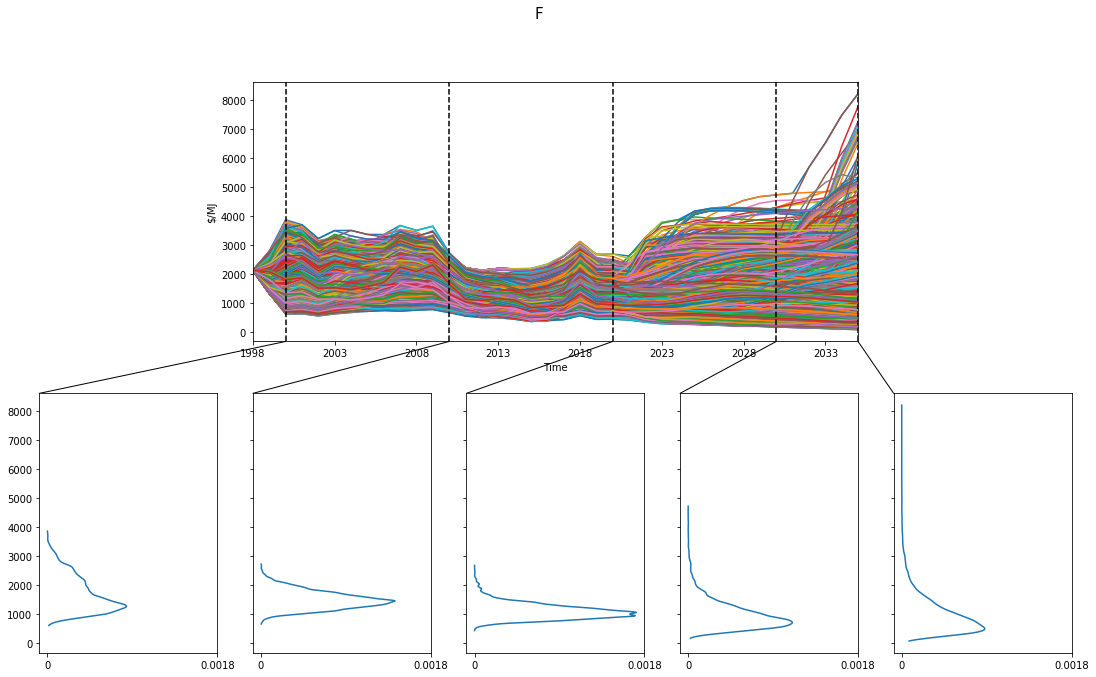

In [193]:
from EMAworkbench.ema_workbench.analysis.plotting import multiple_densities, PlotType
from EMAworkbench.ema_workbench.analysis.plotting_util import Density 
ooi = 'F'
outcomes[ooi] = F_j_house_df.values
fig, ax_env = multiple_densities(experiments, outcomes, outcomes_to_show = ooi,
                                 points_in_time=[2000-startYear,2010-startYear,2020-startYear,2030-startYear,2035-startYear], 
                                 density = Density.KDE, grouping_specifiers=None , titles={ooi}, ylabels={ooi: "$"}, legend=True,
                                 fill=False, plot_type=PlotType.ENV_LIN)

#Change x labels to years
ax_env['F']['main plot'].set_xticklabels(simulationYears[range(0,len(simulationYears),5)])

## Show labels
# labels = ax_env['F']['main plot'].get_xticklabels()
# for l in labels:
#     print (l.get_text)


fig[0].suptitle("{}".format(ooi), fontsize=15)
fig[0].set_size_inches(18.5, 10.5)

In [ ]:
population = pd.read_csv('postgres_public_household_forecast_victoria.csv')


# Analysis

<img src="classification.png" alt="Drawing" style="width: 600px;"/>
